(173, 2)
prix           float64
date    datetime64[ns]
dtype: object
        prix
count  173.0
mean    20.2
std      1.6
min     17.2
25%     18.8
50%     20.3
75%     21.7
max     22.7


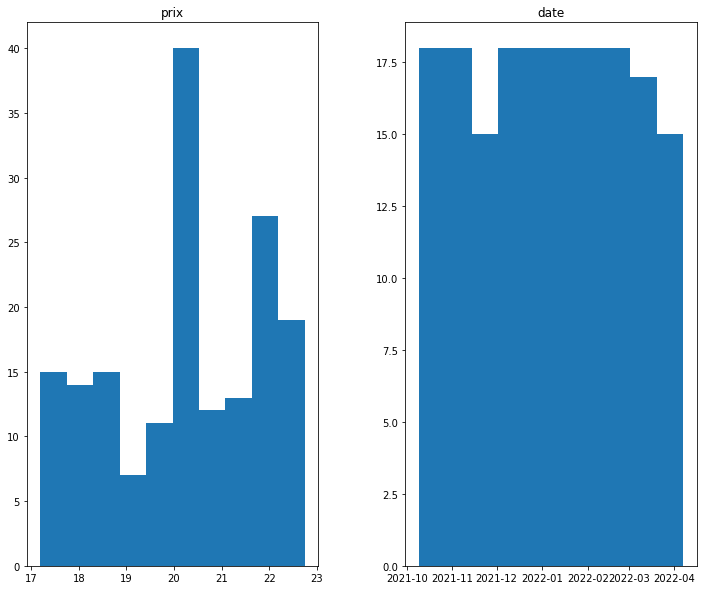

ValueError: Expected 2D array, got 1D array instead:
array=[ 79.  10.  31. 154.  37. 145. 116. 160. 170.  50. 103. 117.  27. 166.
  40.  34.  65.  52. 112.  88. 133.  90.  43.  48.  42.  69. 100. 119.
   2. 142.  83.  49.  67.  71.  72.  78. 158. 169.  70. 167.  73.  93.
 152.   4.  89.   7. 165. 109. 105.   6. 139. 108.  94.  29.  22. 156.
  46. 130.  74.  26.  33.  14.  97.  91.  75. 138. 150. 110.   9. 115.
   8.  19.  58.  23.  54.  12.  77. 135. 128.  55. 168.   5.  99.  59.
  35. 123.  17.  53.  28.  95.  87. 148.  21.  56.  15.  30. 137.   3.
 118. 101.  92.   1.  57.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import *
import sklearn.linear_model
import sklearn.preprocessing
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.ion()

def convert_datelist_counterlist(list_date):
    liste = []
    cpt = 0
    for date in list_date:
        liste.append(cpt)
        cpt = cpt+1
    return liste

filename = "ak-47-asiimov-field-tested_buff.csv"
dataset = pd.read_csv(filename)

dataset["prix"] = dataset["prix"].astype(float)
dataset["date"] = pd.to_datetime(dataset["date"])

# analyses sommaires
print(dataset.shape)

# on consulte les types des données:
print(dataset.dtypes)

# aperçu des stats de chaque colonne
pd.set_option('precision', 1)
print(dataset.describe())

# histograms
dataset.hist(bins=10,figsize=(12,10),grid=False)
plt.show()

# on calcule les corréaltions entre colonnes (coeff. de correlation de Pearson)
pd.set_option('precision', 2)
dataset.corr(method='pearson')

# Setting X and Y axis

# Train / Validation / Test split (60%/20%/20%)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=8) # 0.25 x 0.8 = 0.2


alpha_values = range(150, 251, 1)
alpha_values

scores =[]
for alpha in alpha_values:
    # alpha est fixé (comme mu=mu0)
    monModele = sklearn.linear_model.Ridge(alpha=alpha)
    
    # je converge theta vers theta^*
    monModele.fit(X_train, Y_train)
    
    score = monModele.score(X_val, Y_val)
    scores.append(score)
    print(alpha, score, monModele.score(X_train, Y_train))

plt.plot(alpha_values, scores)
alpha_etoile = np.argmax(np.array(scores))

monModele = sklearn.linear_model.Ridge(alpha=alpha_etoile)
monModele.fit(X_train, Y_train)
monModele.score(X_train, Y_train), monModele.score(X_val, Y_val), monModele.score(X_test, Y_test)

Y_train_pred = monModele.predict(X_train)
print("train error", sklearn.metrics.mean_squared_error(Y_train_pred, Y_train))

Y_test_pred = monModele.predict(X_test)
print("test error", sklearn.metrics.mean_squared_error(Y_test_pred, Y_test))

